In [1]:
import warnings
warnings.filterwarnings("ignore")
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [2]:
import cv2
def check_cam():
    cap1 = cv2.VideoCapture(0)
    cap2 = cv2.VideoCapture(1)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')

    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        cv2.imshow('Webcam 1', frame1)
        cv2.imshow('Webcam 2', frame2)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcams and destroy all windows
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()
# check_cam()

In [3]:
import numpy as np
import cv2
import random
import pygame
import pickle

def init_cameras(id1=0, id2=1):
    '''Инициализация и возврат 2х камер'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')
    return cap1, cap2
    
def get_frame():
    '''Функция захвата фреймов с 2х камер, предполагает, что устройства уже открыты глобально'''
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    return (frame1, frame2)

def setup_pygame(width, heigth):
    '''Инииализация и возврат экрана'''
    pygame.init()
    screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
    screen.fill((255, 255, 255))  # white
    return screen

def create_points(n_points, window_width, window_heigth):
    '''Функция создания точек по периметру экрана, между которыми будет бегать курсор 
    в количестве n_points на каждой из сторон экрана, порядок точек образует как бы 2 змейки'''
    points = [] 
    x1 = np.linspace(0, window_width, n_points, dtype = 'int') #как линейное пространство от 0 до 
    y1 = np.array([0, window_heigth]*(n_points//2)) #максимальной ширины в количестве n_points
    x2 = np.array([0, window_width]*(n_points//2))
    y2 = np.linspace(window_heigth, 0, n_points, dtype = 'int')
    points = list(zip(np.append(x1,x2), np.append(y1,y2)))

    return points

def move_to_points(screen, list_of_points, n, speed = 9999, capture = True):
    '''Функция генерации данных, принимает на вход pygame.screen, список крайних точек между которыми
    она добавит промежуточные точки в количестве n, speed - скорость перехода между точками, флаг 
    capture указывает на то нужно ли сохранять захваты с камер. Функция предполагает что если capture = True
    то глобально уже существуют два устройства opencv: cap1 и cap2, которые через фунцию get_frame вернут
    2 изображения, которые будут сохранены как соответствующие записи в результирующем списке. Таким же
    образом будут сохранены координаты курсора. '''    
    data = [] # Результат работы функции накапливается здесь
    clock = pygame.time.Clock() #Часы для задания скорости
    for ((sx, sy),(ex,ey)) in zip(list_of_points[:-1], #Берем координаты текущей и 
                                  list_of_points[1:]): #следующей точки
        for x, y in zip(np.linspace(sx, ex, n, dtype='int'), #Бежим по промежуточным координатам
                        np.linspace(sy, ey, n, dtype='int')):#
            
            for event in pygame.event.get(): #Для прерывания цикла кнопкой q
                if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                    pygame.quit()

            screen.fill((255, 255, 255)) #Заливаем экран       
            pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
            clock.tick(speed) #Скорость            
            pygame.display.update() #Обновляем экран          
    
            if capture: #Делаем захват с камер, если нужно
                frame1, frame2 = get_frame()
            else:
                frame1, frame2 = [],[]
            data.append({'coords': (x,y), 'camera1':frame1, 'camera2':frame2}) #Делаем текущую запись
    pygame.quit()  #Закрываем экран   
    return data

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
n_points = 8
WINDOW_WIDTH = 1920
WINDOW_HEIGTH = 1080

In [5]:
def make_data():
    points = create_points(n_points, WINDOW_WIDTH, WINDOW_HEIGTH)
    screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH)

    cap1, cap2 = init_cameras()
    input()
    data = move_to_points(screen, points, n=128, capture=True)
    return data
# data = make_data()

In [6]:
# with open('frames.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('frames2.pickle', 'rb') as handle:
        data = pickle.load(handle)    

In [8]:
for record in data:
    record['coords'] = (record['x'], record['y'])

(1254, 263)


<Figure size 640x480 with 0 Axes>

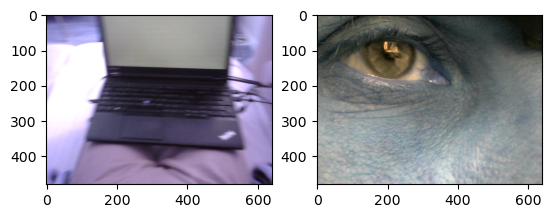

In [9]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
item = random.choice(data)
img1, img2, x, y = item['camera1'], item['camera2'], item['x'], item['y']

plt.figure()
f, axis = plt.subplots(1,2)
print((int(x),int(y)))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axis[0].imshow(img1)
axis[1].imshow(img2)


In [10]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
from torch import nn
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler


VAL_TEST_RATIO = 0.5
TRAIN_VALTEST_RATIO = 0.7

class EyeDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        camera1 = self.data[idx]['camera1']
        camera2 = self.data[idx]['camera2']
        coords = self.data[idx]['coords']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return camera1, camera2, coords

def collate_batch(batch):
    camera1, camera2, coords = [],[],[]
    for _data in batch:    
#         print(_data)
        camera1.append(_data[0]/256)
        camera2.append(_data[1]/256)
        coords.append((_data[2][0]/WINDOW_WIDTH, _data[2][1]/WINDOW_HEIGTH))       
    camera1, camera2, coords = np.array(camera1), np.array(camera2), np.array(coords)
#     return torch.HalfTensor(camera1), torch.HalfTensor(camera2), x, y
    return torch.FloatTensor(camera1), torch.FloatTensor(camera2), torch.FloatTensor(coords)
    

train_records, val_test_records = train_test_split(data, train_size=TRAIN_VALTEST_RATIO, 
                                             random_state=42)
val_records, test_records = train_test_split(val_test_records, train_size=VAL_TEST_RATIO, 
                                             random_state=42)

In [11]:
len(train_records), len(val_records), len(test_records)

(2777, 595, 596)

In [12]:
train_dataset, val_dataset, test_dataset = EyeDataset(train_records), EyeDataset(val_records), EyeDataset(test_records)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

In [13]:
%%timeit
item = next(iter(train_loader))

197 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
item

{'x': 1254,
 'y': 263,
 'camera1': array([[[ 33,  25,  55],
         [ 32,  26,  51],
         [ 32,  28,  49],
         ...,
         [155, 137, 189],
         [155, 137, 189],
         [153, 136, 187]],
 
        [[ 34,  27,  64],
         [ 31,  28,  62],
         [ 30,  31,  63],
         ...,
         [157, 139, 187],
         [157, 138, 185],
         [156, 137, 184]],
 
        [[ 37,  28,  63],
         [ 35,  29,  61],
         [ 35,  33,  63],
         ...,
         [155, 139, 187],
         [155, 138, 185],
         [154, 137, 184]],
 
        ...,
 
        [[153, 145, 205],
         [152, 144, 210],
         [150, 142, 213],
         ...,
         [ 53,  46,  80],
         [ 59,  51,  88],
         [ 66,  58,  96]],
 
        [[153, 145, 207],
         [151, 142, 210],
         [149, 140, 214],
         ...,
         [ 55,  45,  78],
         [ 61,  48,  86],
         [ 67,  54,  92]],
 
        [[153, 145, 207],
         [150, 143, 209],
         [148, 142, 213],
        

In [15]:
vgg11_1 = models.vgg11(pretrained=True)
vgg11_2 = models.vgg11(pretrained=True)
precls_out = 8

In [16]:
for i in [5,5]:
    del (vgg11_1.classifier[i])
    del (vgg11_2.classifier[i])

vgg11_1.classifier[3]= nn.Linear(4096, precls_out)
vgg11_2.classifier[3]= nn.Linear(4096, precls_out)

In [17]:
class EyeTracker(nn.Module):
    def __init__(self, precls_out):
        super(EyeTracker, self).__init__()
        self.vgg1 = vgg11_1
        self.vgg2 = vgg11_2
        self.dropout = nn.Dropout(1)
        self.fc1 = nn.Linear(precls_out*2, precls_out)
        self.fc2 = nn.Linear(precls_out, 2)
        self.activ = nn.ReLU()

    def forward(self, image1, image2):
        out1 = self.vgg1(image1)
        out1 = self.dropout(out1)
        out2 = self.vgg1(image2)
        out1 = self.dropout(out2)

        out = torch.cat((out1, out2),dim=1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.activ(out)
        out = self.fc2(out)       
        return out   

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = nn.MSELoss()
        mse_loss = mse(y_pred, y_true)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EyeTracker(8).to(device)#.half()


In [19]:
# for param in model.parameters():
#     param.data = param.data.half()
#     print(param.dtype)
    

In [33]:
%%time
from torch.optim import Adam, AdamW

EPOCHS = 10
lr_cnn = 1e-5
lr_cls = 1e-3

criterion = RMSELoss()
criterion = nn.MSELoss()
scaler = GradScaler()

optimizer_cnn = Adam([
    {'params': model.vgg1.features.parameters()},
    {'params': model.vgg2.features.parameters()}], lr = lr_cnn)

optimizer_cls = Adam([
    {'params': model.vgg1.classifier.parameters()},
    {'params': model.vgg2.classifier.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}], lr = lr_cls)




def train(model,criterion, optimizer_cnn, optimizer_cls,
          EPOCHS, train_loader, val_loader, half=False):
    train_history = []
    val_history = []
    best_loss = 5
    for epoch in range(EPOCHS):
        model.train()
        pbar = tqdm(train_loader)
        for batch in pbar:
            optimizer_cnn.zero_grad()           
            optimizer_cls.zero_grad()     
            image1, image2, coords = batch
            image1 = image1.permute(0,3,2,1).to(device)#.half()
            image2 = image2.permute(0,3,2,1).to(device)#.half()
            target = coords.to(device)
            if half:
                with autocast():
                    out = model(image1, image2)
                    loss = criterion(out, target)
            else:
                out = model(image1, image2)
                loss = criterion(out, target)
            loss.backward()

            optimizer_cnn.step()        
            optimizer_cls.step()  

            train_history.append(loss.detach().cpu().numpy())  
            pbar.set_description(f'''Train Loss: {train_history[-1]:.2f}, 
                                 emb_lr: {optimizer_cnn.param_groups[0]['lr']:.2E},
                                 cls_lr: {optimizer_cls.param_groups[0]['lr']:.2E}''')  

        '''Валидация'''
        model.eval()
        cum_val_loss = 0 
        with torch.no_grad():
            for batch in val_loader:
                image1, image2, coords = batch
                image1 = image1.permute(0,3,2,1).to(device)#.half()
                image2 = image2.permute(0,3,2,1).to(device)#.half()
                target = coords.to(device)
                if half:
                    with autocast():
                        out = model(image1, image2)
                        val_loss = criterion(out, target).cpu().item()                
                else:
                    out = model(image1, image2)
                    val_loss = criterion(out, target).cpu().item()                
                cum_val_loss += val_loss
        cum_val_loss = np.mean(cum_val_loss)        
        val_history.append(cum_val_loss)  
        print(f'Val_loss: {cum_val_loss:.3f} Train loss: {loss:.3f}\n') 
    return model, train_history, val_history
    
model, train_history, val_history = train(model,criterion, optimizer_cnn, optimizer_cls,
                                          EPOCHS, train_loader, val_loader, half=False)

  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.209 Train loss: 0.091



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.308 Train loss: 0.089



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.249 Train loss: 0.087



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.179 Train loss: 0.124



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.222 Train loss: 0.078



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.243 Train loss: 0.088



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.243 Train loss: 0.083



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.206 Train loss: 0.087



  0%|          | 0/174 [00:00<?, ?it/s]

Val_loss: 4.198 Train loss: 0.048



  0%|          | 0/174 [00:00<?, ?it/s]

KeyboardInterrupt: 

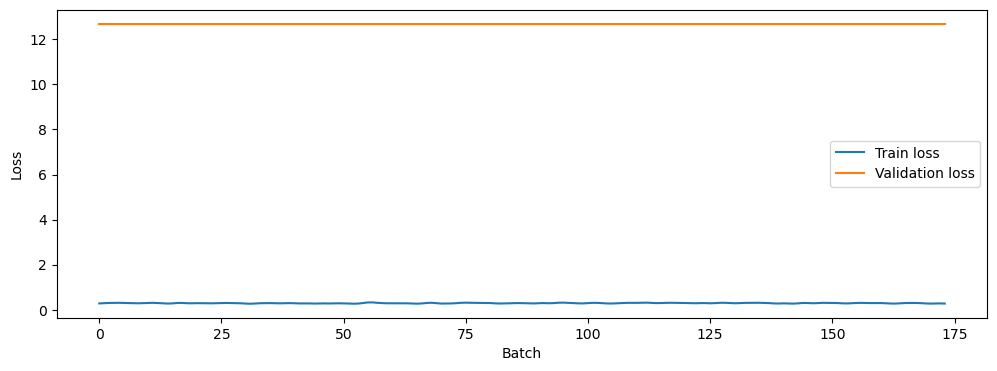

In [30]:
from scipy.ndimage.filters import gaussian_filter1d
def plot_history(train_history, val_history):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(gaussian_filter1d(train_history, sigma=1), label='Train loss')
    ax.plot(gaussian_filter1d(val_history, sigma=1), label='Validation loss')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    
plot_history(train_history, np.array([[item]*174 for item in val_history]).reshape(-1))

In [24]:
x.shape


()

In [25]:
torch.Tensor(np.concatenate([[x], [y]], axis = 0)).permute(1,0).shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 2